# Abstract

- **Data Cleaning**: Find out the outfitters for both "Signals" and "ClosePrice", and use linear interpolate to correct.
- **Signal Embedding**: This is time-series dataset, we can use embeeding method to build more reliable new features. Note that "Signal" cannot be used for corresponding "ClosePrice" prediction, need to do extra shift.
- **Feature Importance**: Look into the correlation between embedding signals and "ClosePrice". 
- **Model**: Build baseline model for feature exam.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_excel("ResearchDatasetV2.0.xlsx")

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 3 columns):
Date          667 non-null int64
Signal        667 non-null float64
ClosePrice    667 non-null float64
dtypes: float64(2), int64(1)
memory usage: 15.7 KB


,Date,Signal,ClosePrice
0,20120103,3.107767,127.495
1,20120104,3.107282,127.700
2,20120105,3.099757,128.040
3,20120106,3.134223,127.710
4,20120109,3.135922,128.020


## Data Cleaning

According to the plot of both "ClosePrice" and "Signal", we can obviously see there are several outliers. In order to detect all possible outliers, I adopt Z-Score method here.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021CE0705710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000021CE0ACD588>], dtype=object)

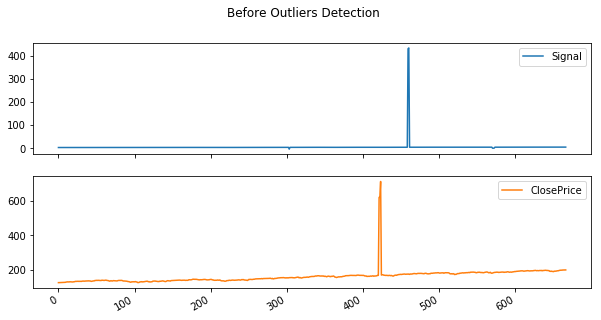

In [4]:
# Simple Visualization & Error Detection

data[["Signal", "ClosePrice"]].plot(subplots=True, title="Before Outliers Detection", figsize=(10, 5))

In [5]:
# Z-Score to find outliers index
# Define customized function for outliers detection

def detect_outliers():
    z_score = np.abs(stats.zscore(data[["Signal", "ClosePrice"]]))
    row_number, col_number = np.where(z_score > 3)

    price_error_index = row_number[np.where(col_number == 1)]
    signal_error_index = row_number[np.where(col_number == 0)]

    return price_error_index, signal_error_index

 
# Outliers interpolation, use Linear interpolate method to correct error points
# Define customized function for outliers interpolation

def interpolate_outliers(price_error_index, signal_error_index):
    data.loc[price_error_index, "ClosePrice"] = np.nan
    data["ClosePrice"] = data["ClosePrice"].interpolate()

    data.loc[signal_error_index, "Signal"] = np.nan
    data["Signal"] = data["Signal"].interpolate()

price_error_index:  [421 422 423] 
signal_error_index:  [459 460]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021CE1EF3128>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000021CE1F1A630>], dtype=object)

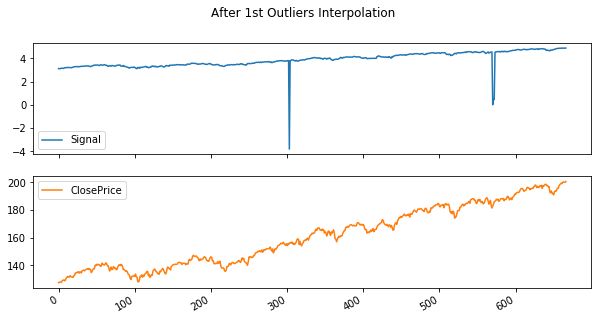

In [6]:
# Data Cleaning


# Detection 1st
price_error_index, signal_error_index = detect_outliers()
print("price_error_index: ", price_error_index, "\nsignal_error_index: ", signal_error_index)

# Interpolation 1st 
interpolate_outliers(price_error_index, signal_error_index)

# Visualization 1st
data[["Signal", "ClosePrice"]].plot(subplots=True, title="After 1st Outliers Interpolation", figsize=(10, 5))

**Comments: **
According to the first visualization, we find there are still some outliers for "Signal", since their values are relativelt small thus aren't detected for the first time. We need to repeat the steps again.

price_error_index:  [] 
signal_error_index:  [303 570 571 572]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021CE1F76A58>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000021CE20031D0>], dtype=object)

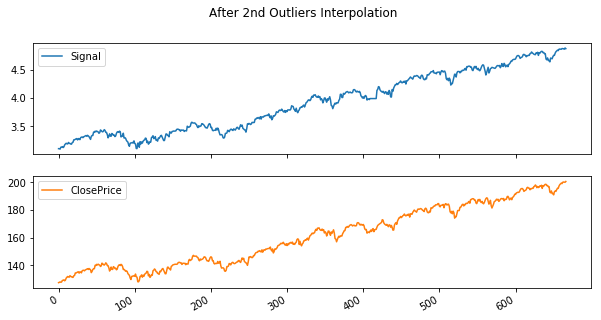

In [7]:
# Detection 2nd
price_error_index, signal_error_index = detect_outliers()
print("price_error_index: ", price_error_index, "\nsignal_error_index: ", signal_error_index)

# Interpolation 2nd 
interpolate_outliers(price_error_index, signal_error_index)

# Visualization 2nd
data[["Signal", "ClosePrice"]].plot(subplots=True, title="After 2nd Outliers Interpolation", figsize=(10, 5))

In [8]:
# Detection 3rd
price_error_index, signal_error_index = detect_outliers()
print("price_error_index: ", price_error_index, "\nsignal_error_index: ", signal_error_index)

price_error_index:  [] 
signal_error_index:  []


Now the plots look great! Also according to Z-Score, there is no more outlier. The dataset is well cleaned.

## Embedding Signal & Importance

Because the “Signal” in the table is received at the end of the day, we cannot use signal to predict corresponding "ClosePrice". Thus we need to do extra shift for "Signal", and we will make embedding singals for (1, 3, 5, 10) days to check its predictive power.

[Text(0,0.5,'ClosePrice'),
 Text(0.5,0,'Signal_10'),
 Text(0.5,1,'Signal_10 & ClosePrice')]

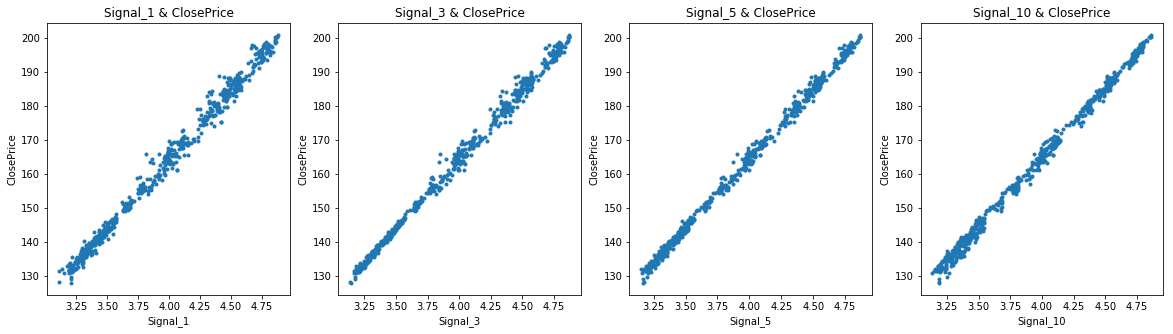

In [9]:
# Embedding Signal

data["Signal_1"] = data["Signal"].shift(1)
data["Signal_3"] = data["Signal_1"].rolling(window=3).mean()
data["Signal_5"] = data["Signal_1"].rolling(window=5).mean()
data["Signal_10"] = data["Signal_1"].rolling(window=10).mean()

# Drop first 10 row for consistency
data = data.iloc[10:]

# Scatter plot for each embedding signal
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharey="col")
ax1.scatter(x=data["Signal_1"], y=data["ClosePrice"], marker=".")
ax1.set(xlabel="Signal_1", ylabel="ClosePrice", title="Signal_1 & ClosePrice")
        
ax2.scatter(x=data["Signal_3"], y=data["ClosePrice"], marker=".")
ax2.set(xlabel="Signal_3", ylabel="ClosePrice", title="Signal_3 & ClosePrice")

ax3.scatter(x=data["Signal_5"], y=data["ClosePrice"], marker=".")
ax3.set(xlabel="Signal_5", ylabel="ClosePrice", title="Signal_5 & ClosePrice")

ax4.scatter(x=data["Signal_10"], y=data["ClosePrice"], marker=".")
ax4.set(xlabel="Signal_10", ylabel="ClosePrice", title="Signal_10 & ClosePrice")

According to the scatter plots, we can roughly see that "Signal_5" and "Signal_10" scatters are more concentrated, thus have stronger relationship with "ClosePrice" than "Signal_1" and "Signal_3". Now let's look into the correlation coefficient for each embedding signal.

,ClosePrice
Signal_1,0.996018
Signal_3,0.997707
Signal_5,0.998454
Signal_10,0.998007


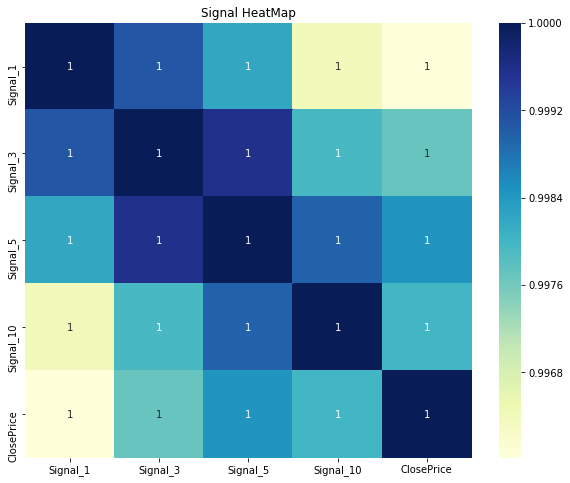

In [10]:
import seaborn as sns

x_col = ["Signal_1", "Signal_3", "Signal_5", "Signal_10", "ClosePrice"]
data_norm = (data[x_col] - data[x_col].mean()) / data[x_col].std()

_, ax = plt.subplots(figsize=(10, 8))
ax.set(title="Signal HeatMap")
sns.heatmap(data_norm.corr(), cmap='YlGnBu', ax=ax, annot=True)

data_norm.corr()[["ClosePrice"]].loc[["Signal_1", "Signal_3", "Signal_5", "Signal_10"]]

"Signal_10" has the strongest correlationship with "ClosePrice"

# Baseline Model

According to previous analysis for Signal, here we build a naive Linear Regression Model for "ClosePrice" pridiction by using "Signal_10" as variable.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

est = LinearRegression()

X = data_norm["Signal_10"].values.reshape(-1, 1)
y = data_norm["ClosePrice"].T.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

est.fit(X_train, y_train)
print("The model score is: ", est.score(X_test, y_test))

The model score is:  0.995902238535


# Summary

- **Viability**: According to the correlation plot and the correaltion coefficient, we can tell the `Signal` has very strong positive correlation with `ClosePrice` thus great predictive power. However, we need to do more feature engineering work to gain better predictive result, for example, can use time-series weighting average to do embedding, can try more embedding window size to find the best.

- **Shortcomings**: Intuitively, the `signal` is a combination of multiple features `[f1, f2, ..., fn]`. Although the `signal` has very ideal predictive power and the analysis turns out we can easily build a linear model to predict the `ClosePrice`, this might be a problem if we want to make a probabilistic prediction instead of point estimation. Since when doing portfolio investment, we can use probabilities to manage ratio and hedging. The orinal multiple features [f1, f2, ..., fn] probably hold mnore information while combination will lose it. Meanwhile, using too much embedding signals by same signal could lead to `multicollinearity` problem. Actually, I'm doubting how the `Singal` got calculated, since in real world case such powerful signal is impossible.

- **TODO**: We can use XGBoost package to gather more information about the signal predictive power. Can use cross validation to build a model to test. In this project, we focus on the `Signal` variable, however the `date` variable is also important, since both `Singal` & `ClosePrice` are time-series data.

- **Recommendation**: As I state in the `Shortcomings`, building portfolio need probabilistic prediction instead of point estimation. So it probably a great idea to build a stochastic process model, we can look into the distribution of `ClosePrice_Change`. A well designed time-series model is usually better than a simple GLM. If there is enough datasize, we can also adopt RNN framework to do prediction.